<a href="https://colab.research.google.com/github/wangleiphy/ml4p/blob/main/5_diffprogram/inverse_schrodinger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import grad, value_and_grad

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!nvidia-smi
jax.devices()

Fri Jul 16 03:00:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

[GpuDevice(id=0, process_index=0)]

Consider the following "inverse Schrodinger problem": optimize a one-dimensional potential $V(x)$ to match its ground-state density to a given target density. This problem comes from the [lecture note](https://math.mit.edu/~stevenj/18.336/adjoint.pdf) of Steven G. Johnson at MIT.

The computation involves solving the Schrodinger equation
$$
\left( -\frac{1}{2} \frac{d^2}{d x^2} + V(x) \right) \psi_0(x) = E_0 \psi_0(x).
$$
Fortunately, such an eigen-decomposition process is differentiable, thus allows us to compute the gradient via the machinery of AD.




First, set up the 1D axis and a target density:

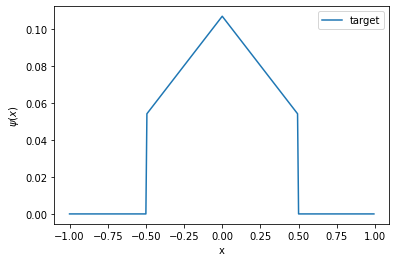

In [ ]:
xmin, xmax, N = -1., 1., 300
xmesh = jnp.linspace(xmin, xmax, N, endpoint=False)                                                                                                             
target = np.zeros(N)                                                    
idx = (np.abs(xmesh) < 0.5)                                             
target[idx] = 1. - np.abs(xmesh[idx])                              
target /= jnp.linalg.norm(target)

plt.plot(xmesh, target, label="target")
plt.xlabel("x")
plt.ylabel("$\psi(x)$")
plt.legend()

The kinetic energy term is constructed by using a finite-difference representation of the second-order derivative. On the other hand, the potential term is diagonal.

In [ ]:
h = (xmax - xmin) / N
K = -0.5/h**2 * (jnp.diag(-2 * jnp.ones(N))
               + jnp.diag(jnp.ones(N - 1), k=1)
               + jnp.diag(jnp.ones(N - 1), k=-1))

In [ ]:
def make_loss(K, target):
    def loss_fn(potential): 
        H = K + jnp.diag(potential)
        _, psis = jax.scipy.linalg.eigh(H)
        psi0 = psis[:, 0]
        loss = jnp.abs(psi0**2 - target**2).sum()
        return loss
    return loss_fn

We initialize the potential as that of a harmonic oscillator. For training, we use the quasi-Newton (L-BFGS) optimizer.

In [ ]:
init_potential = 0.5 * xmesh**2
loss_fn = make_loss(K, target)
loss = loss_fn(init_potential)
print("initial loss:", loss)

import scipy.optimize
def value_and_grad_numpy(f):
    def val_grad_f(*args):
        value, grad = value_and_grad(f)(*args)
        return np.array(value), np.array(grad)
    return val_grad_f
results = scipy.optimize.minimize(value_and_grad_numpy(loss_fn), np.array(init_potential),
                                  method="L-BFGS-B", jac=True, options={'gtol': 1e-07})
print("success:", results.success, "\nniterations:", results.nit, "\nfinal loss:", results.fun)

initial loss: 0.38652714355091977
success: True 
niterations: 987 
final loss: 0.024938118793835066


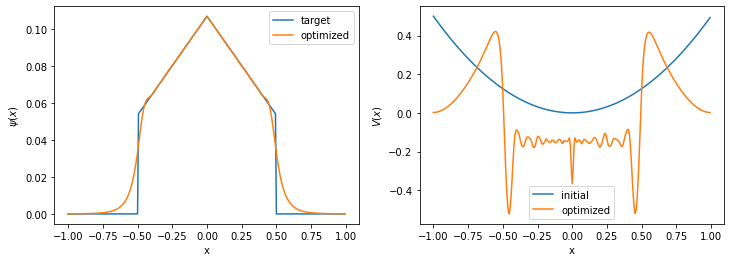

In [ ]:
fig, (ax_psi, ax_potential) = plt.subplots(1, 2, figsize=(12, 4))

ax_psi.plot(xmesh, target, label="target")
H = K + jnp.diag(results.x)
_, psis = jax.scipy.linalg.eigh(H)
psi0 = psis[:, 0]
ax_psi.plot(xmesh, jnp.abs(psi0), label="optimized")
ax_psi.set_xlabel("x")
ax_psi.set_ylabel("$\psi(x)$")
ax_psi.legend()

ax_potential.plot(xmesh, init_potential, label="initial")
ax_potential.plot(xmesh, results.x/300, label="optimized")
ax_potential.set_xlabel("x")
ax_potential.set_ylabel("$V(x)$")
ax_potential.legend()

In view of discontinous nature of the funny-looking target wave function, the optimization result is satisfying!

To dive deeper into the AD of eigen-decomposition, note the differention of the eigenvalue equation $A v_i = \lambda_i v_i$ results to the following relations:
$$
\begin{eqnarray}
d \lambda_0 =& v_0^T dA v_0, \\
d v_0 =& \sum_{i \neq 0} \frac{1}{\lambda_0 - \lambda_i} v_i v_i^T dA v_0.
\end{eqnarray}
$$
These are nothing but the standard formulas of perturbation theory. We thus can manually implement the jvp rule of eigen-decomposition as follows: (See the jax documentation about the [basics](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html) and [customization](https://jax.readthedocs.io/en/latest/notebooks/Custom_derivative_rules_for_Python_code.html) of jvp and vjp mechanisms.)

In [ ]:
@jax.custom_jvp
def symeig(A):
    eigvals, eigvectors = jax.scipy.linalg.eigh(A)
    eigval, eigvector = eigvals[0], eigvectors[:, 0]
    return eigval, eigvector

@symeig.defjvp
def symeig_jvp(primals, tangents):
    A, = primals
    dA, = tangents
    eigvals, eigvectors = jax.scipy.linalg.eigh(A)
    eigval, eigvector = primal_out = eigvals[0], eigvectors[:, 0]

    deigval = eigvector.dot(dA).dot(eigvector)
    F = eigvals - eigvals[:, None] + jnp.eye(A.shape[0])
    F = 1. / F - jnp.eye(A.shape[0])
    deigvector = eigvectors.dot( (F * eigvectors.T.dot(dA).dot(eigvectors))[:, 0] )
    tangent_out = deigval, deigvector

    return primal_out, tangent_out

NameError: ignored

One can convince the correctness of this manual implementation by checking the gradients:

In [ ]:
def make_loss2(K, target):
    def loss_fn(potential): 
        H = K + jnp.diag(potential)
        _, psi0 = symeig(H)
        loss = jnp.abs(psi0**2 - target**2).sum()
        return loss
    return loss_fn
loss_fn2 = make_loss2(K, target)

grad1 = grad(loss_fn)(init_potential)
grad2 = grad(loss_fn2)(init_potential)
jnp.allclose(grad1, grad2)

DeviceArray(True, dtype=bool)

**Explore more**: Note that we only need the ground state of a sparse Hamiltonian, one can instead resort to sparse eigensolvers such as [Lanczos algorithm](https://en.wikipedia.org/wiki/Lanczos_algorithm). It turns out one can also devise the `jvp` and `vjp` rule for this calculation.

See, e.g., Steven G. Johnson's [lecture note](https://math.mit.edu/~stevenj/18.336/adjoint.pdf) and [https://journals.aps.org/prb/abstract/10.1103/PhysRevB.101.245139](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.101.245139). You can keep track of related features in this JAX issue https://github.com/google/jax/issues/1531. 


